In [1]:
# pd.set_option('max_rows', None)
# pd.set_option('max_colwidth', None)
# pd.describe_option('max_colwidth')

In [2]:
# pd.reset_option("all")

# Set-up

In [3]:
import pandas as pd
import regex as re
import string
import numpy as np
import os
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('tagsets')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from numpy.linalg import norm
from scipy.spatial.distance import pdist
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from nltk.stem.porter import PorterStemmer
import random

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


# Connect to Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/MyDrive/')

Drive already mounted at /content/MyDrive/; to attempt to forcibly remount, call drive.mount("/content/MyDrive/", force_remount=True).


In [5]:
os.chdir('/content/MyDrive/MyDrive/Solicitations/Co-Ags')

# Import the Cooperative Agreement Files

Point to where the files sit and create a list of them.

In [6]:
files = os.listdir('/content/MyDrive/MyDrive/Solicitations/Co-Ags')
files = [f for f in files if f[-1] == 't']

The files below will need to be read in differently as they are not structurally similar to the others (ex. sections don't end with 'END OF SECTION').

In [7]:
prob_files = ['Water for Agriculture  Amended RFA.txt',
              'Notice of Funding Opportunity (NOFO) 72039119RFA00001 - Transform FINAL.txt',
              '72060821RFA00001, Religious and Ethnic Minorities Activity.txt'
              ]

Create the initial dataframe that has the Section A for each of the solicitations:

In [8]:
df = pd.DataFrame(columns=['RFA', 'line_string'])

for f in list(set(files) - set(prob_files)):
  soli_df = pd.read_table(f)
  soli_df.rename(columns={soli_df.columns[0]: "line_string"}, inplace = True)
  soli_df.line_string = soli_df.line_string.str.strip()

  if len(soli_df.loc[soli_df.line_string.str.contains(r"SECTION\s*A")].index) > 2:
    sec_lines_start = soli_df.loc[soli_df.line_string.str.contains(r"SECTION\s*A")].index[1] # pick up 2nd mention of SECTION A to not pick up table of contents if applicable
  else:
    sec_lines_start = soli_df.loc[soli_df.line_string.str.contains(r"SECTION\s*A")].index[0]

  sec_lines_end = soli_df.loc[soli_df.line_string.str.contains(r"END\s*OF\s*SECTION\s*A")].index[0]

  soli_df = soli_df.loc[sec_lines_start:sec_lines_end] # slice the text to only grab beg. and end. of SECTION A
  soli_df['sect_letter'] = 'A'

  sections_df = soli_df.dropna()
  sections_df= sections_df.groupby('sect_letter').line_string.apply(lambda x: '\n'.join(x)).to_frame() # create one long string of this section
  beg = sections_df['line_string'].str.find('SECTION')[0] 
  end = sections_df['line_string'].str.find('END OF SECTION')[0]
  sections_df['line_string'] = sections_df['line_string'][0][beg:end] # remove any text before and after the beg. and end of the section
  sections_df['RFA'] = f # create solicitation column 

  df = df.append(sections_df)
  df.index.rename('section', inplace = True)

  df['line_string'] = df['line_string'].str.replace('http\S+|www.\S+', '', case=False) # remove the weblinks 
  df['line_string'] = df['line_string'].str.replace('●|✔|■|➔', '', case=False) # remove the special symbols
  df['line_string'] = df['line_string'].str.replace('activity', '', case=False) # remove the synonyms for proposal as these are somewhat like stop words
  df['line_string'] = df['line_string'].str.replace('goal', '', case=False)
  df['line_string'] = df['line_string'].str.replace('purpose', '', case=False)
  df['line_string'] = df['line_string'].str.replace('approach', '', case=False)
  df['line_string'] = df['line_string'].str.replace('objective', '', case=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


Once the non-problematic files are read in, then read in the problematic ones:

In [9]:
for f in prob_files:
  soli_df = pd.read_table(f)
  soli_df.rename(columns={soli_df.columns[0]: "line_string"}, inplace = True)
  soli_df.line_string = soli_df.line_string.str.strip()

  if f == 'Water for Agriculture  Amended RFA.txt':
    sec_lines_start = soli_df.loc[soli_df.line_string.str.contains(r"SECTION\s*A")].index[1]
    sec_lines_end = soli_df.loc[soli_df.line_string.str.contains(r"SECTION\s*A")].index[2]

  elif f == '72027821RFA00005 Sawt.txt':
    sec_lines_start = 103
    sec_lines_end = soli_df.loc[soli_df.line_string.str.contains(r"SECTION\s*A")].index[0]

  elif f == 'Notice of Funding Opportunity (NOFO) 72039119RFA00001 - Transform FINAL.txt':
    sec_lines_start = 0
    sec_lines_end = soli_df.loc[soli_df.line_string.str.contains(r"SECTION\s*A")].index[0]

  else:
    sec_lines_start = soli_df.loc[soli_df.line_string.str.contains(r"SECTION\s*A")].index[0]
    sec_lines_end = soli_df.loc[soli_df.line_string.str.contains(r"SECTION\s*A")].index[1]    

  soli_df = soli_df.loc[sec_lines_start:sec_lines_end]
  soli_df['sect_letter'] = 'A'

  sections_df = soli_df.dropna()
  sections_df= sections_df.groupby('sect_letter').line_string.apply(lambda x: '\n'.join(x)).to_frame()

  if f == 'Notice of Funding Opportunity (NOFO) 72039119RFA00001 - Transform FINAL.txt':
    beg = 0
  else:
    beg = sections_df['line_string'].str.find('SECTION')[0]

  end = sections_df['line_string'].str.find('END OF SECTION')[0]


  sections_df['line_string'] = sections_df['line_string'][0][beg:end]
  sections_df['RFA'] = f

  df = df.append(sections_df)
  df.index.rename('section', inplace = True)
  
  df['line_string'] = df['line_string'].str.replace('http\S+|www.\S+', '', case=False)
  df['line_string'] = df['line_string'].str.replace('●|✔|■|➔', '', case=False)
  df['line_string'] = df['line_string'].str.replace('activity', '', case=False)
  df['line_string'] = df['line_string'].str.replace('goal', '', case=False)
  df['line_string'] = df['line_string'].str.replace('purpose', '', case=False)
  df['line_string'] = df['line_string'].str.replace('approach', '', case=False)
  df['line_string'] = df['line_string'].str.replace('objective', '', case=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [10]:
df = df.reset_index()
df.head()

,section,RFA,line_string
0,A,NOFO 72049220RFA00003- Sustainable Coastal Fis...,SECTION A – PROGRAM DESCRIPTION\nA.1 AUTHORITY...
1,A,LEAP NOFO 72067022RFA00001.txt,SECTION A: PROGRAM DESCRIPTION\nThis\nfunding\...
2,A,NOFO No. 72016722RFA00002 - Private Sector Par...,SECTION A-PROGRAM DESCRIPTION\nThis\nfunding\n...
3,A,NOFO_72068520RFA00001_Niger_MN_final.txt,SECTION A: PROGRAM DESCRIPTION\nThis funding o...
4,A,Young People for Integrity and Accountability ...,SECTION A: PROGRAM DESCRIPTION\nThis funding o...


Identify the Request for Application (RFA) number from the file name:

In [11]:
RFA_num = [i[i.find('7'):i.find('7')+16] for i in df.RFA]

df['RFA_num'] = RFA_num

# the files below can't have the RFA extracted from the file name
df.loc[df.RFA == 'NOFO TOFI.txt', 'RFA_num'] = '72038621RFA00001'
df.loc[df.RFA == 'NOFO 72060322RFA000002 - Youth Enployment 7-22.txt', 'RFA_num'] = '72060322RFA00002'
df.loc[df.RFA == 'Young People for Integrity and Accountability (YPIA) Activity - NOFO.txt', 'RFA_num'] =  '72061322RFA00004'
df.loc[df.RFA == 'Water for Agriculture  Amended RFA.txt', 'RFA_num'] = '72062019RFA00002'

df.head()

,section,RFA,line_string,RFA_num
0,A,NOFO 72049220RFA00003- Sustainable Coastal Fis...,SECTION A – PROGRAM DESCRIPTION\nA.1 AUTHORITY...,72049220RFA00003
1,A,LEAP NOFO 72067022RFA00001.txt,SECTION A: PROGRAM DESCRIPTION\nThis\nfunding\...,72067022RFA00001
2,A,NOFO No. 72016722RFA00002 - Private Sector Par...,SECTION A-PROGRAM DESCRIPTION\nThis\nfunding\n...,72016722RFA00002
3,A,NOFO_72068520RFA00001_Niger_MN_final.txt,SECTION A: PROGRAM DESCRIPTION\nThis funding o...,72068520RFA00001
4,A,Young People for Integrity and Accountability ...,SECTION A: PROGRAM DESCRIPTION\nThis funding o...,72061322RFA00004


#LIBRARY Table

The metadata for the solicitations include the official title of the program, an abbreviation of the title, the agency (country office) posting the opportunity, the category of which the opportunity is targeting, and finally the beginning and ending indexes of the purpose of the opportunity.

In [12]:
LIBRARY = pd.read_excel('co_ag_mapping.xlsx')
LIBRARY = LIBRARY.iloc[: , :8]
LIBRARY['PURPOSE START'] = LIBRARY['PURPOSE START'].astype(int)
LIBRARY['PURPOSE END'] = LIBRARY['PURPOSE END'].astype(int)
LIBRARY.head()

,OPPORTUNITY NUMBER,OPPORTUNITY TITLE,TITLE ABR.,AGENCY CODE,AGENCY NAME,CATEGORY,PURPOSE START,PURPOSE END
0,72011423RFA00001,USAID Educating the Future Activity,Educ. the Future,USAID-GEO,Georgia USAID-Tbilisi,Education,10,16
1,72016923RFA00001,Innovation and Media Fund Activity in Serbia,Innov. and Media Fund in Serbia,USAID-SER,Serbia USAID-Belgrade,Regional Development,8,56
2,72067423RFA00004,Achieving and Sustaining HIV/TB Epidemic Contr...,Achiev. and Sustain. HIV/TB Epid. Cont. in Lim...,USAID-SAF,South Africa USAID-Pretoria,Health,130,140
3,72067423RFA00003,Achieving and Sustaining HIV/TB Epidemic Contr...,Achiev. and Sustain. HIV/TB Epid. Cont. in Kwa...,USAID-SAF,South Africa USAID-Pretoria,Health,40,57
4,72011123RFA00001,Media Integrity and Resilience in Armenia Acti...,Media Integ. and Resil. in Armenia,USAID-ARM,Armenia USAID-Yerevan,Democracy and Governance,143,152


The table below groups together our metadata with each opportunity's full and unaltered Section A:

In [13]:
df = pd.merge(LIBRARY, df, left_on = 'OPPORTUNITY NUMBER', right_on = 'RFA_num')
df = df.drop(['RFA', 'RFA_num'], axis = 1)
df.head()

,OPPORTUNITY NUMBER,OPPORTUNITY TITLE,TITLE ABR.,AGENCY CODE,AGENCY NAME,CATEGORY,PURPOSE START,PURPOSE END,section,line_string
0,72011423RFA00001,USAID Educating the Future Activity,Educ. the Future,USAID-GEO,Georgia USAID-Tbilisi,Education,10,16,A,SECTION A: PROGRAM DESCRIPTION\nThis funding o...
1,72016923RFA00001,Innovation and Media Fund Activity in Serbia,Innov. and Media Fund in Serbia,USAID-SER,Serbia USAID-Belgrade,Regional Development,8,56,A,SECTION A: PROGRAM DESCRIPTION\nThis funding o...
2,72067423RFA00004,Achieving and Sustaining HIV/TB Epidemic Contr...,Achiev. and Sustain. HIV/TB Epid. Cont. in Lim...,USAID-SAF,South Africa USAID-Pretoria,Health,130,140,A,SECTION A: PROGRAM DESCRIPTION\nAchieving and ...
3,72067423RFA00003,Achieving and Sustaining HIV/TB Epidemic Contr...,Achiev. and Sustain. HIV/TB Epid. Cont. in Kwa...,USAID-SAF,South Africa USAID-Pretoria,Health,40,57,A,SECTION A: PROGRAM DESCRIPTION\nAchieving and ...
4,72011123RFA00001,Media Integrity and Resilience in Armenia Acti...,Media Integ. and Resil. in Armenia,USAID-ARM,Armenia USAID-Yerevan,Democracy and Governance,143,152,A,SECTION A: PROGRAM DESCRIPTION\nThis funding o...


In [14]:
testy = df.query('`OPPORTUNITY NUMBER` == "72012222RFA00001"')['line_string'].str.split(r'\n', expand = True).stack().to_frame()
testy
# testy.iloc[72:75].apply(lambda x: '\n'.join(x)).to_frame()

0
6 0                       SECTION A: PROGRAM DESCRIPTION
  1    : Reduce the burden of tuberculosis (TB) in Uz...
  2    : Achieve 2027 National/ United Nations High L...
  3    through optimized reach, cure, prevent and sus...
  4    quality, people-centered, affordable, and inte...
...                                                  ...
  686  throughout programming to implementation es, p...
  687  Applicants should further discuss how lessons ...
  688  partners, and collaborators to be used for mak...
  689  interventions designed to achieve expected int...
  690                                                  [

[691 rows x 1 columns]

# TOKEN Table

In [15]:
TOKEN = pd.DataFrame(columns=['OPPORTUNITY NUMBER', 'line_string'])

for x,y,z in zip(LIBRARY['OPPORTUNITY NUMBER'],LIBRARY['PURPOSE START'],LIBRARY['PURPOSE END']):
  temp_goal_df = pd.DataFrame(columns=['OPPORTUNITY NUMBER', 'line_string'])
  query_df = df.query('`OPPORTUNITY NUMBER` == @x')['line_string'].str.split(r'\n', expand = True).stack().to_frame()
  temp_goal_df['line_string'] = query_df.iloc[y:z].apply(lambda x: '\n'.join(x)).to_frame()
  temp_goal_df['OPPORTUNITY NUMBER'] = x

  TOKEN = TOKEN.append(temp_goal_df)

TOKEN.set_index('OPPORTUNITY NUMBER', inplace = True)
TOKEN['line_string'] = TOKEN['line_string'].str.replace(r'\n', ' ').str.strip()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  if sys.path[0] == '':


In [16]:
TOKEN.head()

,line_string
OPPORTUNITY NUMBER,
72011423RFA00001,The of this Program is to strengthen the qual...
72016923RFA00001,USAID/Serbia aims to support the establishment...
72067423RFA00004,"The of this is to support long, healthy live..."
72067423RFA00003,The of USAID’s “Achieving and Sustaining HIV ...
72011123RFA00001,The overall of the is to strengthen the inte...


The function that will create the final TOKEN table needed:

In [17]:
def tokenize(doc_df, remove_pos_tuple=False, ws=False):
    
    # Paragraphs to Sentences
    df = doc_df.line_string\
        .apply(lambda x: pd.Series(nltk.sent_tokenize(x)))\
        .stack()\
        .to_frame()\
        .rename(columns={0:'sent_str'})
    
    # Sentences to Tokens
    # Local function to pick tokenizer
    def word_tokenize(x):
        if ws:
            s = pd.Series(nltk.pos_tag(nltk.WhitespaceTokenizer().tokenize(x)))
        else:
            s = pd.Series(nltk.pos_tag(nltk.word_tokenize(x))) # Discards stuff in between
        return s
            
    df = df.sent_str\
        .apply(word_tokenize)\
        .stack()\
        .to_frame()\
        .rename(columns={0:'pos_tuple'})
    
    # Grab info from tuple
    df['pos'] = df.pos_tuple.apply(lambda x: x[1])
    df['token_str'] = df.pos_tuple.apply(lambda x: x[0])
    if remove_pos_tuple:
        df = df.drop('pos_tuple', 1)
    
    return df

In [18]:
TOKEN = tokenize(TOKEN, ws=False)

In [19]:
TOKEN['term_str'] = TOKEN['token_str'].str.lower().str.replace('[\W_]', '')
TOKEN.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


pos_tuple  pos token_str term_str
OPPORTUNITY NUMBER                                            
72011423RFA00001   0 0       (The, DT)   DT       The      the
                     1        (of, IN)   IN        of       of
                     2      (this, DT)   DT      this     this
                     3  (Program, NNP)  NNP   Program  program
                     4       (is, VBZ)  VBZ        is       is

#PURPOSE Table

In [20]:
PURPOSE = TOKEN[TOKEN.pos.str.match(r'^NNS?$')]\
    .groupby('OPPORTUNITY NUMBER').term_str\
    .apply(lambda x: ' '.join(x))\
    .to_frame()

In [21]:
PURPOSE.head()

,term_str
OPPORTUNITY NUMBER,
72011423RFA00001,quality equality education system quality pres...
72016923RFA00001,establishment investment vehicle fund financin...
72067423RFA00004,lives population control partner districts exe...
72067423RFA00003,hereinafter lives population control usaid aim...
72011123RFA00001,overall integrity information space capacity m...


#Topic Modeling of Opportunities

In [22]:
n_terms = 1000
n_topics = 10
max_iter = 50

In [23]:
tfv = CountVectorizer(stop_words='english')
tf = tfv.fit_transform(PURPOSE.term_str)
TERMS = tfv.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [24]:
lda = LDA(n_components=n_topics, max_iter=max_iter, learning_offset=50., random_state=0)

# THETA Table

In [25]:
THETA = pd.DataFrame(lda.fit_transform(tf), index=PURPOSE.index)
THETA.columns.name = 'topic_id'

In [26]:
THETA.sample(20).style.background_gradient()

topic_id,0,1,2,3,4,5,6,7,8,9
OPPORTUNITY NUMBER,,,,,,,,,,
72067423RFA00003,0.001852,0.001852,0.983332,0.001852,0.001852,0.001852,0.001852,0.001852,0.001852,0.001852
72068520RFA00003,0.307385,0.005556,0.005556,0.648169,0.005556,0.005556,0.005556,0.005556,0.005556,0.005556
72039119RFA00001,0.002941,0.973527,0.002942,0.002941,0.002941,0.002941,0.002942,0.002942,0.002941,0.002941
72064122RFA00008,0.960867,0.004348,0.004348,0.004348,0.004349,0.004348,0.004348,0.004348,0.004348,0.004348
72044223RFA00001,0.990109,0.001099,0.001099,0.001099,0.001099,0.001099,0.001099,0.001099,0.001099,0.001099
72044022RFA00003,0.002273,0.002273,0.979544,0.002273,0.002273,0.002273,0.002273,0.002273,0.002273,0.002273
72066323RFA00002,0.969997,0.003334,0.003334,0.003334,0.003334,0.003334,0.003334,0.003334,0.003334,0.003334
7200AA21RFA00024,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.871427,0.014287
72068523RFA00001,0.968963,0.003448,0.003448,0.003449,0.003448,0.003449,0.003449,0.003448,0.003448,0.003448


# PHI Table

In [27]:
PHI = pd.DataFrame(lda.components_, columns=TERMS)
PHI.index.name = 'topic_id'
PHI.columns.name  = 'term_str'

#TOPICS Table

In [28]:
TOPICS = PHI.stack().to_frame().rename(columns={0:'weight'})\
    .groupby('topic_id')\
    .apply(lambda x: 
           x.weight.sort_values(ascending=False)\
               .head(10)\
               .reset_index()\
               .drop('topic_id',1)\
               .term_str)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  import sys


In [29]:
TOPICS

term_str,0,1,2,3,4,5,6,7,8,9
topic_id,,,,,,,,,,
0,health,education,quality,focus,services,systems,capacity,implementation,actors,pollution
1,information,services,access,women,products,media,trees,society,support,forests
2,control,development,leaders,health,society,youth,community,change,partnerships,needs
3,resilience,capacities,level,shocks,systems,stresses,efforts,populations,interventions,women
4,services,health,quality,governance,corruption,institutions,sector,use,interventions,threats
5,health,quality,media,services,indicators,people,behaviors,students,development,care
6,water,access,community,school,partners,services,resources,capacity,girls,communities
7,sector,education,institutions,health,pollution,air,development,stakeholders,organizations,networks
8,fisheries,biodiversity,management,security,benefits,conservation,level,government,sustainability,livelihoods


In [30]:
TOPICS['label'] = TOPICS.apply(lambda x: str(x.name) + ' ' + ' '.join(x), 1)

In [31]:
TOPICS['doc_weight_sum'] = THETA.sum()

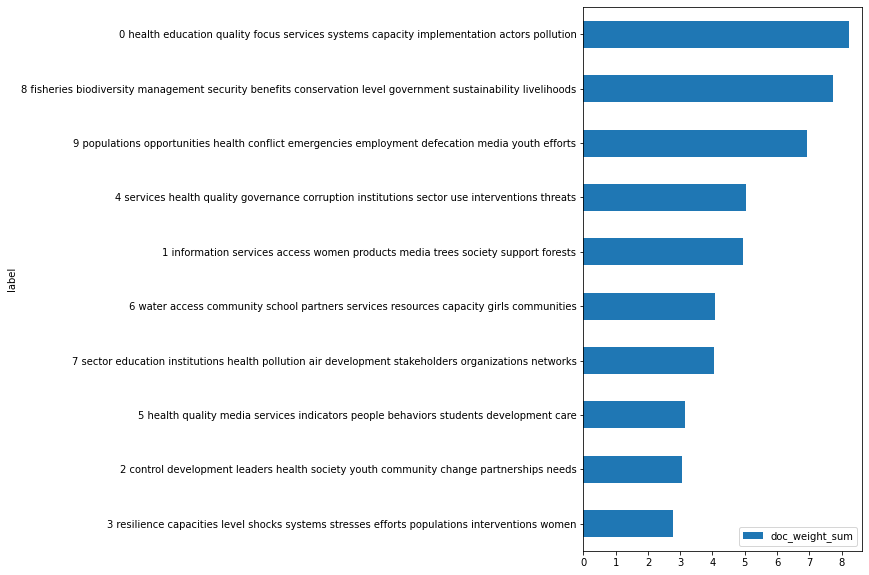

In [32]:
TOPICS.sort_values('doc_weight_sum', ascending=True).plot.barh(y='doc_weight_sum', x='label', figsize=(5,10)) 

# Similarity Scores for Opportunities

These functions will create the TF-IDF matrix and then sort the VOCAB table by the TF-IDF score:

In [33]:
def TFIDF_mat(TOKEN, bag, count_method, tf_method, idf_method):
    
    # Bag of Words
    BOW = TOKEN.groupby(bag+['term_id']).term_id.count()\
    .to_frame().rename(columns={'term_id':'n'})
    BOW['c'] = BOW.n.astype('bool').astype('int')
    
    # Document-Term Matrix
    DTCM = BOW[count_method].unstack().fillna(0).astype('int')
    
    # TF
    if tf_method == 'sum':
        TF = DTCM.T / DTCM.T.sum()

    elif tf_method == 'max':
        TF = DTCM.T / DTCM.T.max()

    elif tf_method == 'log':
        TF = np.log10(1 + DTCM.T)
    
    elif tf_method == 'raw':
        TF = DTCM.T

    elif tf_method == 'double_norm':
        TF = DTCM.T / DTCM.T.max()
        TF = tf_norm_k + (1 - tf_norm_k) * TF[TF > 0] 

    elif tf_method == 'binary':
        TF = DTCM.T.astype('bool').astype('int')
     
    TF = TF.T
    
    # DF
    DF = DTCM[DTCM > 0].count()
    
    # IDF
    N = DTCM.shape[0]
    
    if idf_method == 'standard':
        IDF = np.log10(N / DF)

    elif idf_method == 'max':
        IDF = np.log10(DF.max() / DF) 

    elif idf_method == 'smooth':
        IDF = np.log10((1 + N) / (1 + DF)) + 1
    
    # TFIDF
    TFIDF = TF * IDF
    
    return TFIDF

def VOCABSort(VOCAB, tfidf_mat):
    VOCAB_copy = VOCAB
    VOCAB_copy['tfidf_sum'] = tfidf_mat.sum()
    return VOCAB_copy.sort_values('tfidf_sum', ascending=False).head(20).style.background_gradient(cmap=gradient_cmap, high=1)

In [34]:
VOCAB = TOKEN.term_str.value_counts().to_frame()\
 .rename(columns={'index':'term_str', 'term_str':'n'})\
 .sort_index().reset_index().rename(columns={'index':'term_str'})
VOCAB.index.name = 'term_id'

VOCAB['num'] = VOCAB.term_str.str.match("\d+").astype('int')

Identifying the stop words:

In [35]:
sw = pd.DataFrame(nltk.corpus.stopwords.words('english'), columns=['term_str'])
sw = sw.reset_index().set_index('term_str')
sw.columns = ['dummy']
sw.dummy = 1
VOCAB['stop'] = VOCAB.term_str.map(sw.dummy)
VOCAB['stop'] = VOCAB['stop'].fillna(0).astype('int')

Stemming the term string:

In [36]:
stemmer1 = PorterStemmer()
VOCAB['stem_porter'] = VOCAB.term_str.apply(stemmer1.stem)

In [37]:
TOKEN['term_id'] = TOKEN.term_str.map(VOCAB.reset_index().set_index('term_str').term_id)

Identifying the most frequent part of speech for each term:

In [38]:
VOCAB['pos_max'] = TOKEN.groupby(['term_id', 'pos']).pos.count().unstack().idxmax(1)

In [39]:
VOCAB.head()

,term_str,n,num,stop,stem_porter,pos_max
term_id,,,,,,
0,,850,0,0,,","
1,1,9,1,0,1,CD
2,1019,1,1,0,1019,JJ
3,104,1,1,0,104,CD
4,11,2,1,0,11,CD


# TF-IDF Matrix

In [40]:
TFIDF_mat(TOKEN, bag = ['OPPORTUNITY NUMBER'], count_method = 'n', tf_method = 'sum', idf_method = 'standard')

term_id,0,1,2,3,4,5,6,7,8,9,...,1471,1472,1473,1474,1475,1476,1477,1478,1479,1480
OPPORTUNITY NUMBER,,,,,,,,,,,,,,,,,,,,,
72011423RFA00001,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
72016923RFA00001,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.002327,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
72067423RFA00004,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
72067423RFA00003,0.0,0.002748,0.00000,0.006269,0.000000,0.000000,0.002748,0.000000,0.000000,0.000000,...,0.000000,0.004048,0.000000,0.000000,0.000000,0.000000,0.006269,0.000000,0.000000,0.000000
72011123RFA00001,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
72061222RFA00006,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012244,0.000000
72012222RFA00001,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
72044022RFA00003,0.0,0.000000,0.00000,0.000000,0.000000,0.012311,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008854,0.011534,0.000000
72044022RFA00002,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [41]:
TFIDF = TFIDF_mat(TOKEN, bag = ['OPPORTUNITY NUMBER'], count_method = 'n', tf_method = 'sum', idf_method = 'standard')
TFIDF = TFIDF.reindex(LIBRARY['OPPORTUNITY NUMBER'].to_list())

# DOC Table

In [42]:
DOC = TFIDF.reset_index()['OPPORTUNITY NUMBER']
DOC = DOC.to_frame()
DOC.index.name = 'doc_id'
DOC.head()

,OPPORTUNITY NUMBER
doc_id,
0,72011423RFA00001
1,72016923RFA00001
2,72067423RFA00004
3,72067423RFA00003
4,72011123RFA00001


Create an identifier for each opportunity for the visualizations that will be a combination of the 

In [43]:
DOC['title'] = DOC['OPPORTUNITY NUMBER'].map(
    LIBRARY.set_index('OPPORTUNITY NUMBER')['CATEGORY'] + '-' +
    LIBRARY.set_index('OPPORTUNITY NUMBER')['AGENCY CODE'] + '-' +
    LIBRARY.set_index('OPPORTUNITY NUMBER')['TITLE ABR.']
)

Creating a binary form of the TF-IDF matrix for the jaccard similarity measure:

In [44]:
L0 = TFIDF.astype('bool').astype('int')

# PAIRS Table

The PAIRS table is a one-to-one comparison of each document that will be analyzed.

In [45]:
PAIRS = pd.DataFrame(index=pd.MultiIndex.from_product([DOC.index.tolist(), DOC.index.tolist()])).reset_index()
PAIRS = PAIRS[PAIRS.level_0 < PAIRS.level_1].set_index(['level_0','level_1'])
PAIRS.index.names = ['doc_a', 'doc_b']

In [46]:
PAIRS

Empty DataFrame
Columns: []
Index: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 28), (0, 29), (0, 30), (0, 31), (0, 32), (0, 33), (0, 34), (0, 35), (0, 36), (0, 37), (0, 38), (0, 39), (0, 40), (0, 41), (0, 42), (0, 43), (0, 44), (0, 45), (0, 46), (0, 47), (0, 48), (0, 49), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (2, 3), (2, 4), (2, 5), ...]

[1225 rows x 0 columns]

Calculating the cosine and jaccard similarity between each document:

In [47]:
PAIRS['cosine'] = pdist(TFIDF, 'cosine')
PAIRS['jaccard'] = pdist(L0, 'jaccard')

Highlight the documents with 10 highest cosine similarity scores:

In [48]:
PAIRS.sort_values('cosine', ascending = False).head(10).style.background_gradient('Reds')

Highlight the documents with 10 highest jaccard similarity scores:

In [49]:
PAIRS.sort_values('jaccard', ascending = False).head(10).style.background_gradient('Reds')

,,cosine,jaccard
doc_a,doc_b,,
35,38,0.991263,0.985714
1,16,0.990827,0.981928
17,45,0.999917,0.979381
27,38,0.997823,0.977528
29,45,0.999673,0.977273
27,28,0.999981,0.975000
35,43,0.999939,0.975000
19,28,0.999905,0.974684
10,17,0.999098,0.974138


Function to return the n-highest documents by selected measure:

In [50]:
def comps(RFA_num, measure, n):
  idx = pd.IndexSlice
  doc_id = DOC.query('`OPPORTUNITY NUMBER` == @RFA_num').index[0]

  if doc_id == [*range(len(DOC))][0]:
    a = PAIRS.loc[idx[doc_id, :], :]
    top5_df = pd.concat([a]).sort_values(measure, ascending = False).head(n).reset_index() 

  elif doc_id == [*range(len(DOC))][-1]:
    b = PAIRS.loc[idx[:, doc_id], :]
    top5_df = pd.concat([b]).sort_values(measure, ascending = False).head(n).reset_index() 

  else:
    a = PAIRS.loc[idx[doc_id, :], :]
    b = PAIRS.loc[idx[:, doc_id], :]
    top5_df = pd.concat([a,b]).sort_values(measure, ascending = False).head(n).reset_index() 

  top5_df.doc_a, top5_df.doc_b  = top5_df.doc_a.replace(DOC['title']), top5_df.doc_b.replace(DOC['title'])

  return top5_df[['doc_a', 'doc_b', measure]]

Example of function being called on random opportunity:

In [51]:
comps(random.choice(DOC['OPPORTUNITY NUMBER'].tolist()), 'jaccard', 5)

,doc_a,doc_b,jaccard
0,Environment-USAID-VIE-Biodiversity Conservation,Health-USAID-ETH-Public Health Emerg. Mgmt.,0.974138
1,Environment-USAID-VIE-Biodiversity Conservation,Community Development-USAID-COL-Restor. Our Fu...,0.972973
2,Environment-USAID-VIE-Biodiversity Conservation,"Democracy, Human Rights and Governance-USAID-S...",0.970588
3,Environment-USAID-VIE-Biodiversity Conservation,Democracy and Governance-USAID-ZIM-Young Peopl...,0.968992
4,Health-USAID-KAZ-TB Free Uzbekistan,Environment-USAID-VIE-Biodiversity Conservation,0.960000


In [52]:
def hca(sims, linkage_method='ward', color_thresh=.3, figsize=(20, 15)):
    tree = sch.linkage(sims, method=linkage_method)
    labels = DOC['title'].values
    plt.figure()
    fig, axes = plt.subplots(figsize=figsize)
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh
                               )
    plt.tick_params(axis='both', which='major', labelsize=14)

<Figure size 432x288 with 0 Axes>

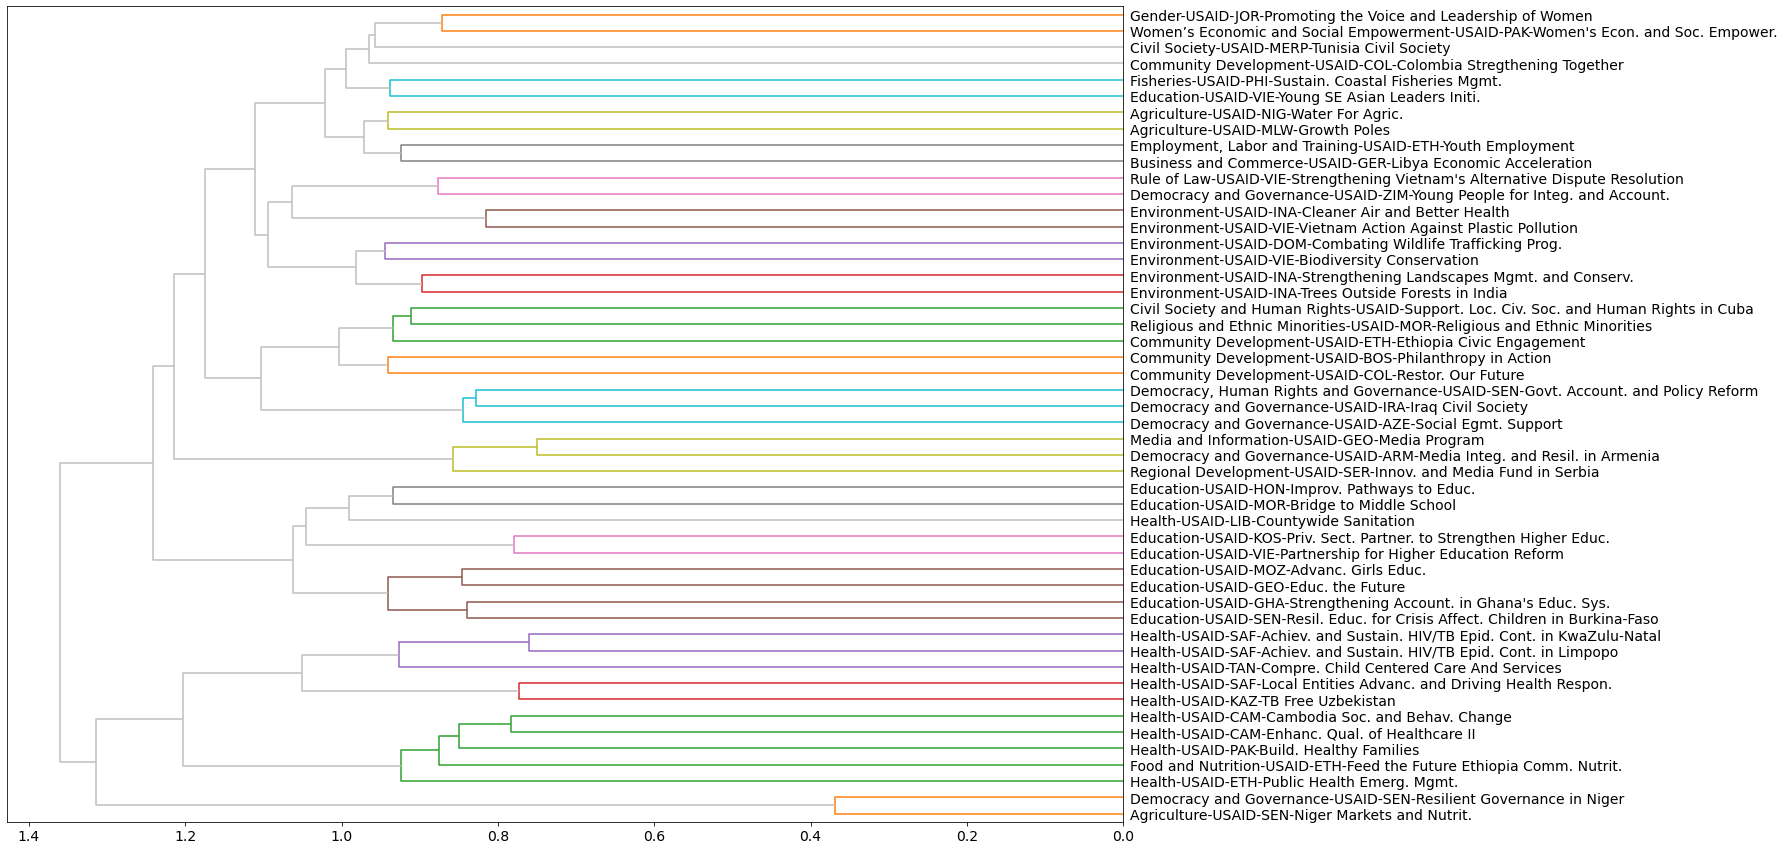

In [53]:
hca(PAIRS.cosine, color_thresh=.95)

<Figure size 432x288 with 0 Axes>

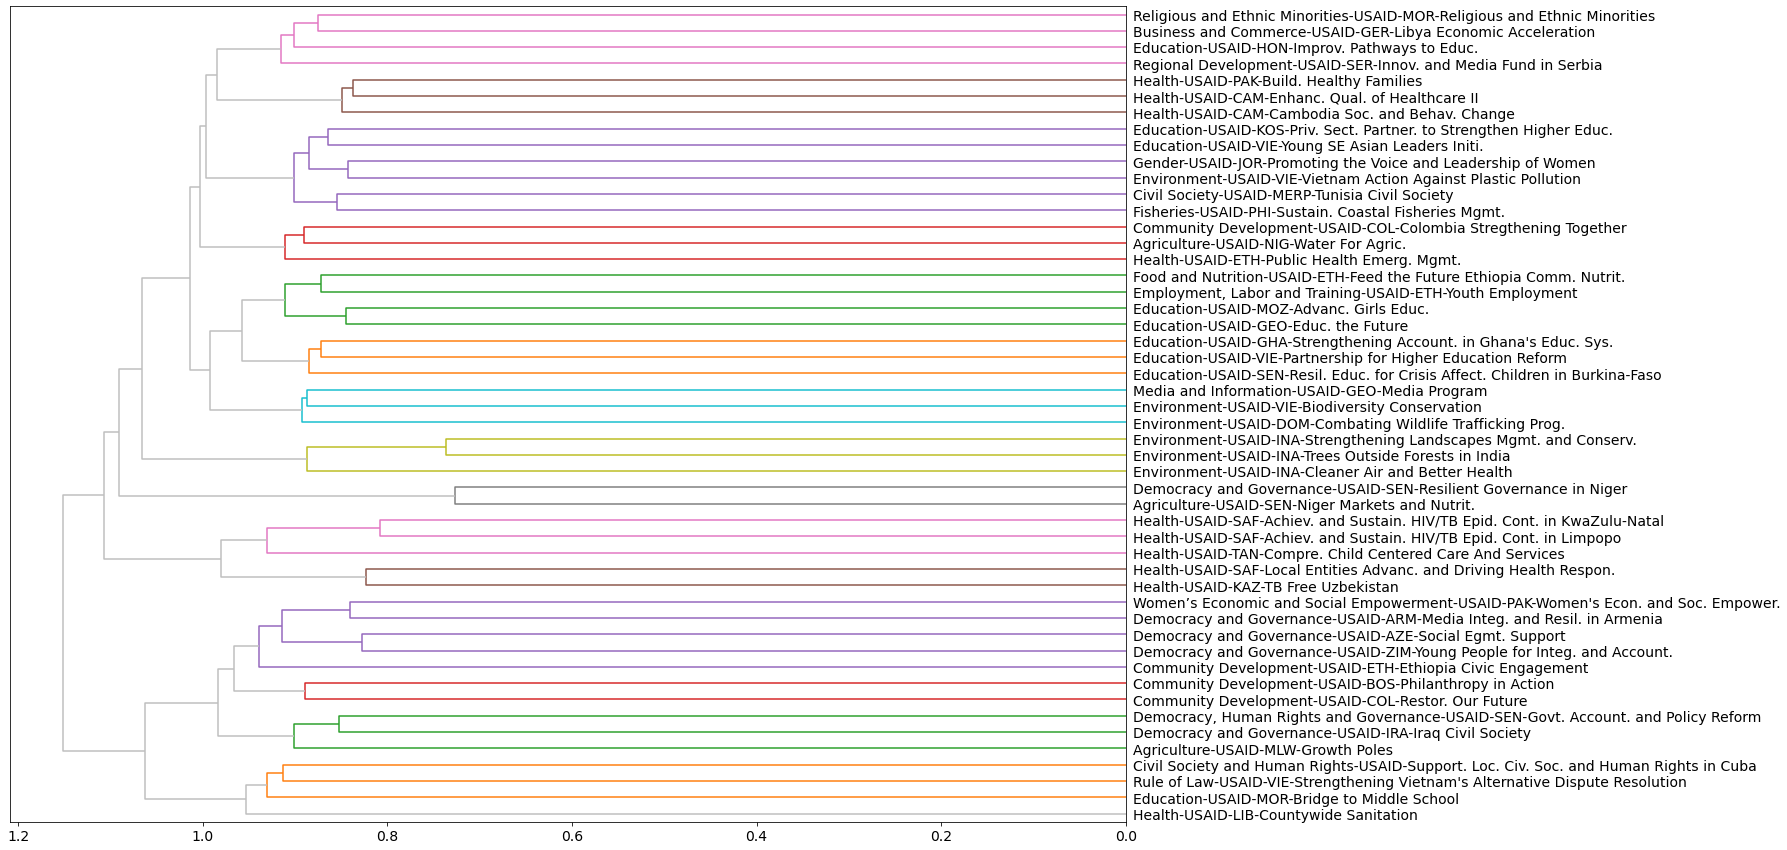

In [54]:
hca(PAIRS.jaccard, color_thresh=.95)